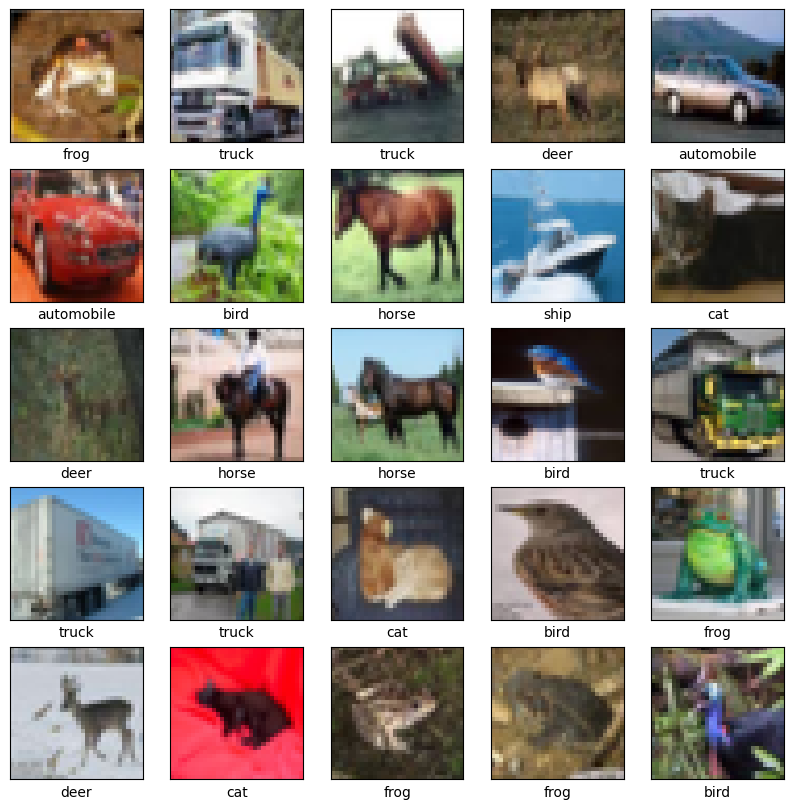

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


In [2]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

print(f"Number of layers in the model: {len(base_model.layers)}")


Number of layers in the model: 19


In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 14982474 (57.15 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 2.3836 - accuracy: 0.1434
Epoch 1: val_accuracy improved from -inf to 0.26360, saving model to vgg16_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 30s 26ms/step - loss: 2.3836 - accuracy: 0.1434 - val_loss: 1.9711 - val_accuracy: 0.2636 - lr: 1.0000e-04
Epoch 2/100
782/782 [==============================] - ETA: 0s - loss: 2.1890 - accuracy: 0.1930
Epoch 2: val_accuracy improved from 0.26360 to 0.39430, saving model to vgg16_best_model.h5
782/782 [==============================] - 20s 26ms/step - loss: 2.1890 - accuracy: 0.1930 - val_loss: 1.6507 - val_accuracy: 0.3943 - lr: 1.0000e-04
Epoch 3/100
780/782 [============================>.] - ETA: 0s - loss: 2.1136 - accuracy: 0.2174
Epoch 3: val_accuracy improved from 0.39430 to 0.43960, saving model to vgg16_best_model.h5
782/782 [==============================] - 20s 26ms/step - loss: 2.1136 - accuracy: 0.2174 - val_loss: 1.5906 - val_accuracy: 0.4396 - lr: 1.0000e-04
Epoch 4/100
780/782 [============================>.] - ETA: 0s - loss: 2.0858 - accuracy: 0.2222
Epoch 4: val_accuracy improved from 0.43960 to 0.47990, saving model to vgg

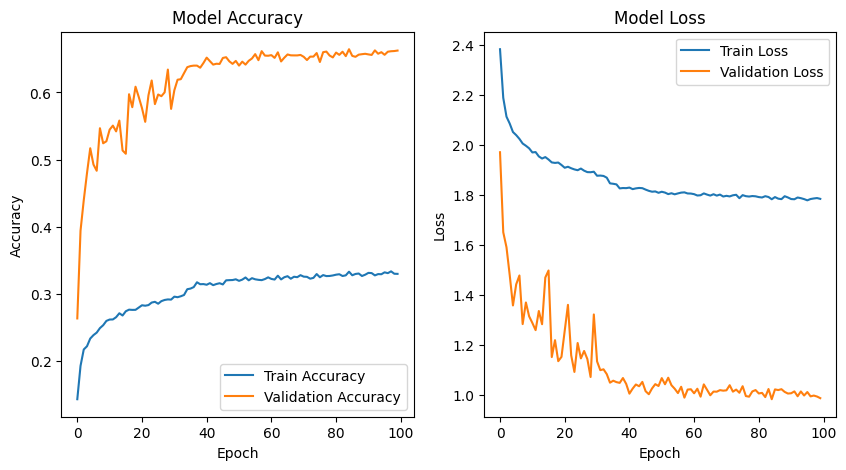

313/313 [==============================] - 3s 9ms/step - loss: 0.9863 - accuracy: 0.6623
Loss: 0.9863442182540894
Accuracy: 0.6622999906539917


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom((-0.2, 0.2)),
    tf.keras.layers.RandomContrast(0.8, 1.2),
    tf.keras.layers.RandomBrightness(0.1),
])


base_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
base_model.trainable = True


for layer in base_model.layers[:-4]:
    layer.trainable = False

inputs = Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = 'vgg16_best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)


history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test),
                    callbacks=[model_checkpoint_callback, reduce_lr])


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
evaluation_results = model.evaluate(x_test, y_test)
print(f"Loss: {evaluation_results[0]}")
print(f"Accuracy: {evaluation_results[1]}")


In [5]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)


313/313 [==============================] - 3s 8ms/step
Precision: 0.6700433236233779
Recall: 0.6623
